# Conser-Vision: Image Classification using Camera Trap Images

Camera traps are a tool used by conservationists to study and monitor a wide range of ecologies while limiting human interference. However, they also generate a vast amount of data that quickly exceeds the capacity of humans to sift through. Machine learning and advances in computer vision can help automate tasks such as species detection and identification, so that humans can spend more time learning from and protecting these ecologies and spend less time manually classifying animal species.

Using real-life images from the Taï National Park in Côte d'Ivoire, this project aims to apply Transfer Learning to create a model based on Convolutional Neural Networks (CNN) that is suitable for classifying 7 types of animal species.

![](https://github.com/vlatko-v/drivendata-Conser-vision-Image-Classification/blob/main/data/train_features/ZJ008342.jpg?raw=1)

In [1]:
pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 37.3 MB/s eta 0:00:00


In [2]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import pandas as pd
from PIL import Image
from tqdm import tqdm

import shutil

from itertools import cycle

# ANN
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img

from tensorflow.keras.applications.densenet import preprocess_input as prepro_input_dn201
import keras_tuner
import keras_cv

#from tensorflow.keras.layers import TFSMLayer

# Scikit-Learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Using TensorFlow backend


In [5]:
# for google colab
#!unrar x drive/MyDrive/drivendata-Conser-vision-Image-Classification.rar

Streaming output truncated to the last 5000 lines.
Extracting  data/train_features/ZJ015373.jpg                              88%  OK 
Extracting  data/train_features/ZJ015374.jpg                              88%  OK 
Extracting  data/train_features/ZJ015375.jpg                              88%  OK 
Extracting  data/train_features/ZJ015376.jpg                              88%  OK 
Extracting  data/train_features/ZJ015377.jpg                              88%  OK 
Extracting  data/train_features/ZJ015378.jpg                              88%  OK 
Extracting  data/train_features/ZJ015379.jpg                              88%  OK 
Extracting  data/train_features/ZJ015380.jpg                              88%  OK 
Extracting  data/train_features/ZJ015381.jpg                              88%  OK 
Extracting  data/train_features/ZJ015382.jpg                              88%  OK 
Extracting  data/train_featur

In [6]:
%run functions.py

### Loading features and labels

In [7]:
train_features = pd.read_csv("data/train_features.csv", index_col="id")
test_features = pd.read_csv("data/test_features.csv", index_col="id")
train_labels = pd.read_csv("data/train_labels.csv", index_col="id")

In [8]:
train_features.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


In [ ]:
test_features.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


In the description of the task, it was mentioned that the images in the training data set were taken at different sites from those in the test data set. This was done to ensure that the trained model generalizes well to unseen cases. Below, the "site" variable was converted to a set to test whether the sites from the training data set truly do not appear in the test data set. The .isdisjoint() function shows that to be the case.

The train-validation split will therefore be made in such a way so that the validation set solely contains exclusive sites not found in the train data set.

In [ ]:
set(train_features["site"].unique()).isdisjoint(set(test_features["site"].unique()))

True

In the train_labels data set we see which images were classified as which species. There is a total of 7 species including images that contains no animals (column "blank").

In [ ]:
train_labels

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
ZJ016483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ016484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZJ016485,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Data exploration

Below we see some examples of the species in their natural habitat.

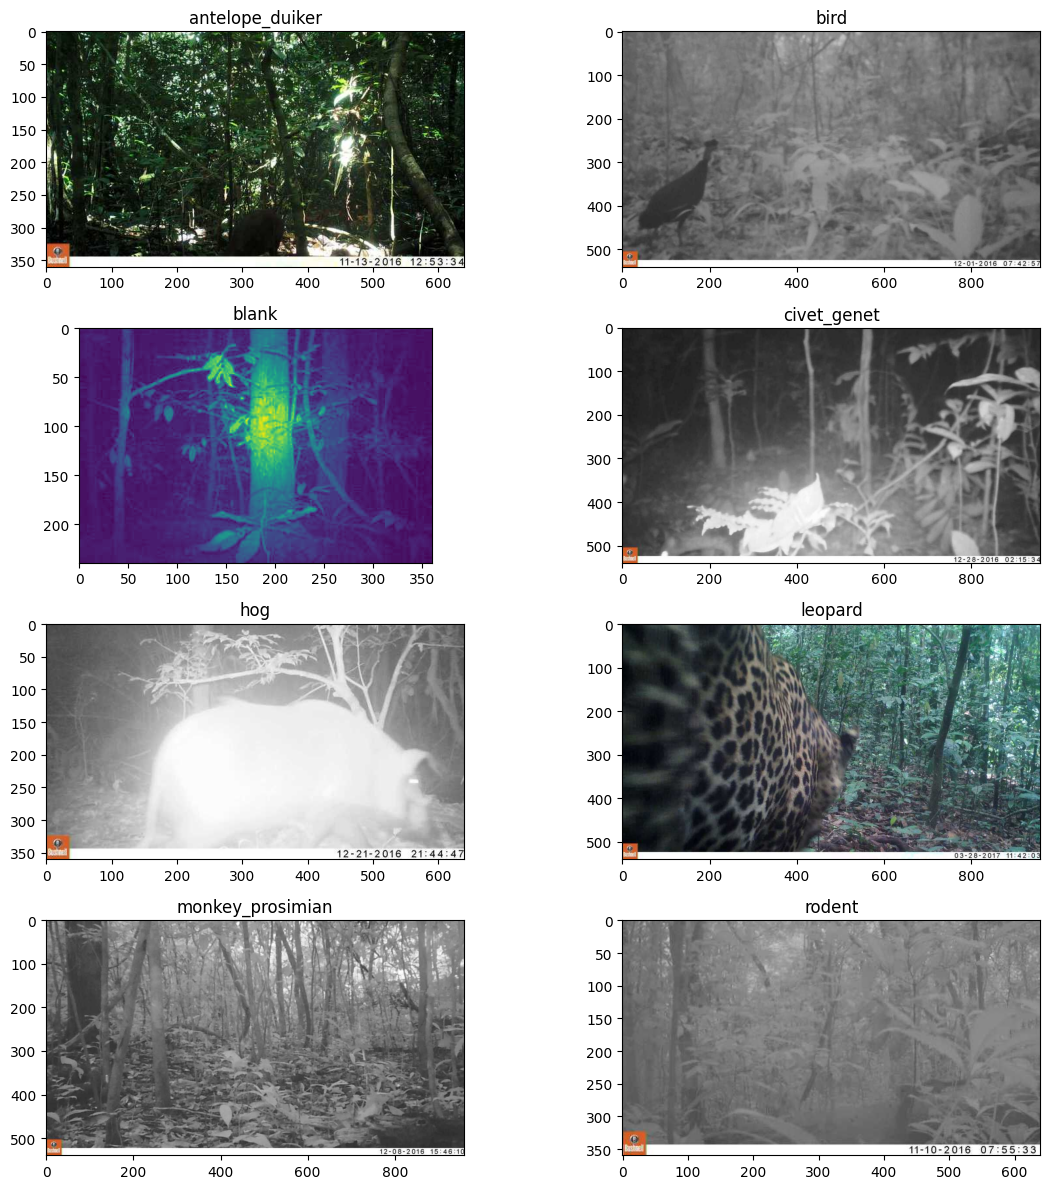

In [ ]:
fig, axes = plt.subplots(4, 2, figsize = (12,12))
axes = axes.flatten()

for i, species in enumerate(train_labels.columns):
    photo_id = train_labels[train_labels[species] == 1].sample(1, random_state = 2).index[0]

    img_path = "data/" + train_features.loc[photo_id].filepath
    img = mpimg.imread(img_path)

    axes[i].imshow(img)
    axes[i].set_title(species)

plt.tight_layout()
plt.show()


It would also be quite interesting to see how many animals appear in the photos. It may be the case that some species appear more frequently than others, which would bias the model towards better classifying those species.

In [ ]:
train_labels.sum(axis=0).reset_index().rename(columns={"index":"species", 0:"number_images"})

,species,number_images
0,antelope_duiker,2474.0
1,bird,1641.0
2,blank,2213.0
3,civet_genet,2423.0
4,hog,978.0
5,leopard,2254.0
6,monkey_prosimian,2492.0
7,rodent,2013.0


In [ ]:
(round(train_labels.sum(axis=0)/len(train_labels),4)*100).reset_index().rename(columns={"index":"species", 0:"percentage_images"})

,species,percentage_images
0,antelope_duiker,15.00
1,bird,9.95
2,blank,13.42
3,civet_genet,14.70
4,hog,5.93
5,leopard,13.67
6,monkey_prosimian,15.11
7,rodent,12.21


<Axes: ylabel='Frequency (%)'>

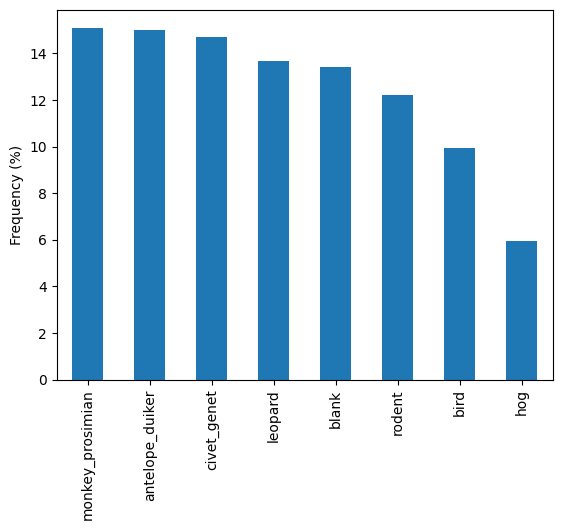

In [ ]:
(round(train_labels.sum(axis=0)/len(train_labels),4)*100).sort_values(ascending=False).plot(ylabel="Frequency (%)", kind = "bar")

As is evident, the data set is not all too balanced. Each species (plus the "blank" class) should appear roughly 12.5% of the time. Here, however, some species only appear ~6% of the time (hog), while others appear in over 15% of the images (prosimian monkey).

Apart from the species, it is also important to see at which sites the images were taken. As can be seen, the number of images taken a some sites is vastly greater than at other sites (e.g. S0060 vs S0190). This will need to be taken into account not only during the model training phase, but also when splitting the data into the training and validation set.

In [ ]:
train_features["site"].value_counts()

site
S0060    1132
S0009     664
S0063     557
S0008     541
S0036     456
         ... 
S0143       3
S0078       2
S0079       2
S0178       2
S0102       1
Name: count, Length: 148, dtype: int64

In [ ]:
train_features["site"].value_counts(normalize=True)

site
S0060    0.068656
S0009    0.040272
S0063    0.033782
S0008    0.032812
S0036    0.027656
           ...   
S0143    0.000182
S0078    0.000121
S0079    0.000121
S0178    0.000121
S0102    0.000061
Name: proportion, Length: 148, dtype: float64

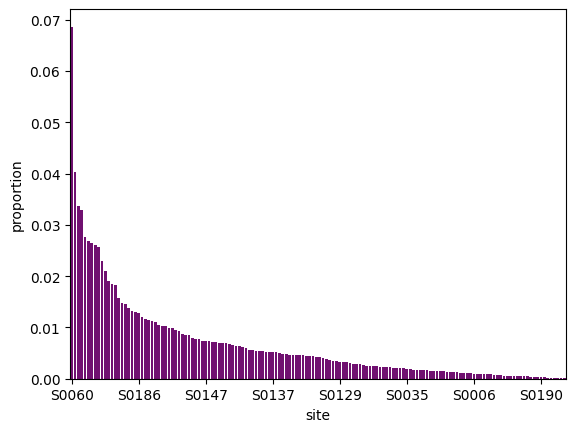

In [ ]:
g = sns.barplot(data = train_features["site"].value_counts(normalize=True).reset_index(), x = "site", y = "proportion", color = "purple")
g.set_xticks(list(range(0, len(train_features["site"].value_counts()), 20)))

### Train-validation split

In [ ]:
site_counts = train_features["site"].value_counts().sort_values(ascending=False).reset_index()
site_counts

,site,count
0,S0060,1132
1,S0009,664
2,S0063,557
3,S0008,541
4,S0036,456
...,...,...
143,S0143,3
144,S0078,2
145,S0079,2
146,S0178,2


As was pointed out, the distribution of images taken at each sites varies considerably (1132 images at the most frequent site vs. 1 image at the least frequent site). Randomly selecting sites for the training and validation set, where neither of them contain images from the same site, therefore replicates a real-life situation where camera traps are set up in entirely new locations. Since no other information is avaiable about the sites, except the site id, the sites did not serve as an additional input variable (feature), but were instead used to split the dataset into train and validation sets, each containing images from exclusive sites.

Moreover, the split was also stratified by species. In order to achieve that, the train_feature and train_label dataframes were merged on the index and then grouped by site. After that, the number of images for each species was calculated by site. A new column with the most frequent species count for each site was created in order to stratify the train-validation split by species.

In [9]:
X_train, X_val, y_train, y_val = stratified_train_val_split(train_features, train_labels)

While the stratification isn't perfect, the results below show a relatively similar distributions of species between the training and validation set.

In [ ]:
pd.DataFrame({"train":y_train.idxmax(axis = 1).value_counts(normalize=True),
              "validation":y_val.idxmax(axis = 1).value_counts(normalize=True)})

,train,validation
antelope_duiker,0.158133,0.123709
bird,0.098684,0.102273
blank,0.137048,0.125000
civet_genet,0.157419,0.112862
hog,0.053266,0.079029
leopard,0.130152,0.158058
monkey_prosimian,0.153773,0.142562
rodent,0.111525,0.156508


The sites between the training and test dataset are disjoint, meaning that no site appears in both sets.

In [ ]:
set(X_val["site"].unique()).isdisjoint(set(X_train["site"].unique()))

True

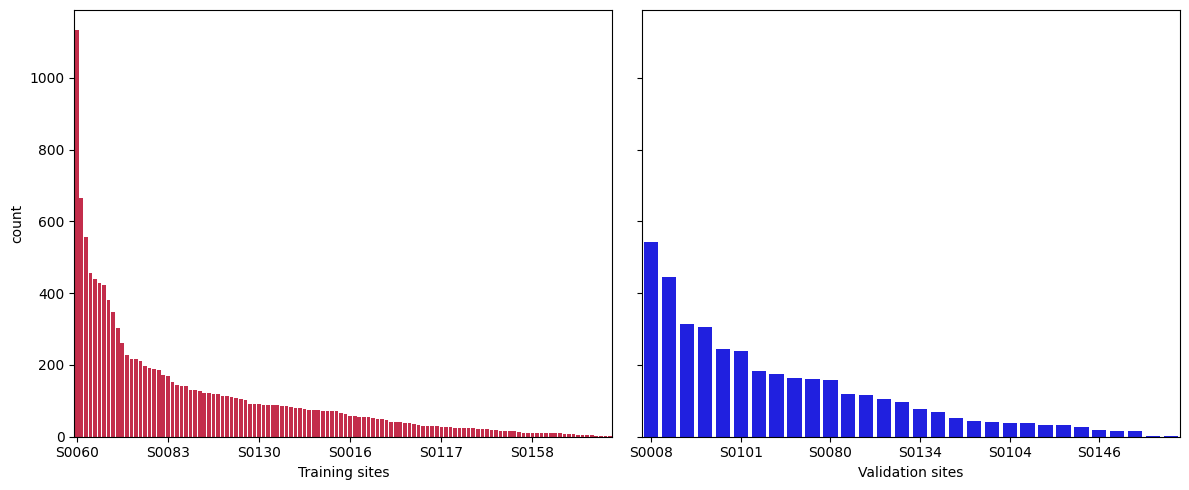

In [ ]:
site_distributions(X_train, X_val, normalize = False)

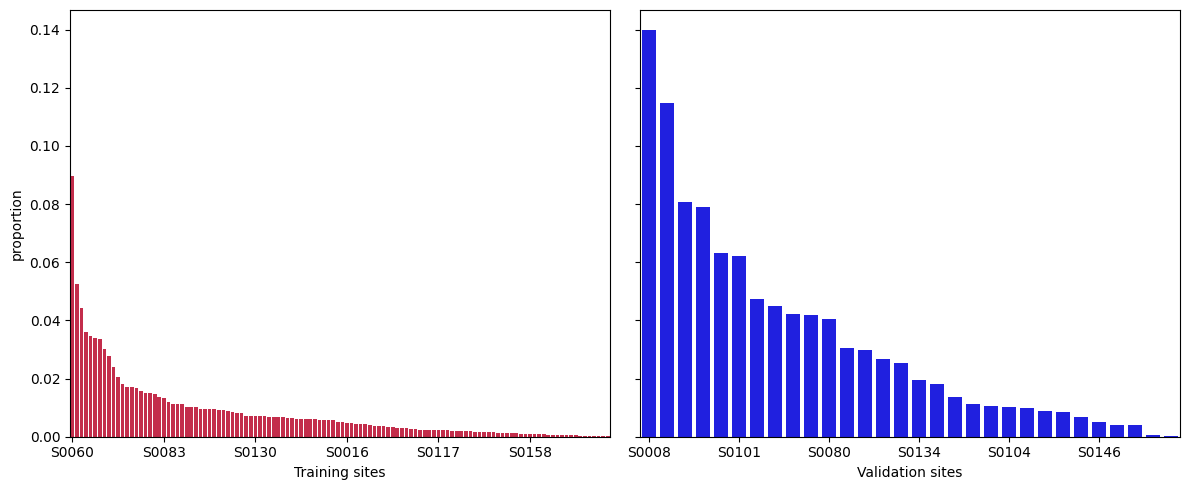

In [ ]:
site_distributions(X_train, X_val, normalize = True)

The distribution of the number of images based on site location is not too similar between the train and validation set. The training set, admittedly, contains most of the sites with the highest number of images, which might skew the results later on. Achieving exlusive sites in both datasets, while stratifying based on species and, at the same time, having a roughly similar distribution of images taken at each site between the training and validation set, is a fine balancing act. For now, all these factors are relatively in sync and the training and validation datasets will be used as such.

In terms of the relative distribution (proportion), the most frequent sites in the validation dataset account for a bigger percentage compared to those in the training dataset. This makes sense, since the validation set contains only ~23% of the total sites.

## Transfer Learning with CNN

Transfer Learning is a machine learning method where a model already developed for a task is reused in another task. There are currently hundreds of different state-of-the-art pre-trained CNN models that can be used as benchmarks for other tasks, even if they are quite different from the original tasks. This way, the training process is generally narrowed down to the final, fully connected layers, which is how this model will be trained.

### Loading the model

As a good starting point is the DenseNet201 model, which was trained on the ImageNet dataset, containing over 14 million annotated images.

In [10]:
densenet_base = keras.applications.DenseNet201(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
# Location of downloaded pre-trained models

!ls -sh ~/.keras/models/*.h5

72M /c/Users/Flatko/.keras/models/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
densenet_base.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

Here, the convolutional layers are frozen and will not be trained upon.

In [11]:
for layers in densenet_base.layers[:]:
    layers.trainable = False

### Loading  and transforming imagesthem

Before the models are applied, the images need to be loaded and transformed into a format that the algorithm can read - namely 4D tensors. The 4 dimensions of these tensors are:

1. Number of images
2. Number of pixels along the width of the image
3. Number of pixels along the height of the image
4. Number of color bands - for colored images the number is usually 3 (red, green, blue)

For easier and faster loading of the dataset, it is common practice for each class (species) to have its own subfolder where the corresponding images are stored. The function "create_species_directory" takes care of that step.

In [ ]:
home_path = r"C:/Users/Flatko/MyGitRepos/drivendata-Conser-vision-Image-Classification/data/"

In [ ]:
create_species_directory(df_train = y_train, df_val = y_val, home_path = home_path)

Now, the images for both the training and the validation set can be loaded and directly tranformed into a numpy array. Specifying the batch size to be 128 prevents bottlenecks in the memory and greatly speeds up the process. The array contains each image's pixel values in each of the three color bands (red, green, blue).

In [ ]:
train = keras.utils.image_dataset_from_directory(directory = "data/train",
                                               batch_size = 128,
                                               image_size = (224,224))

val = keras.utils.image_dataset_from_directory(directory = "data/valid",
                                               batch_size = 128,
                                               image_size = (224,224))


Found 12616 files belonging to 8 classes.
Found 3872 files belonging to 8 classes.


Some pre-trained models, such as DenseNet201, require the data to be additionally preprocessed. From the DenseNet201 Tensorflow documentation page: "The input pixels values are scaled between 0 and 1 and each channel is normalized with respect to the ImageNet dataset." In the end, the result of the preprocessing yields values typically between -1 and 1.

In [ ]:
train_densenet = train.map(lambda x, y: (prepro_input_dn201(x), tf.one_hot(y, depth = 8)))
val_densenet = val.map(lambda x, y: (prepro_input_dn201(x), tf.one_hot(y, depth = 8)))

train_densenet = train_densenet.batch(128).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
val_densenet = val_densenet.batch(128).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

Applying a custom function, the images have been transformed into 4D tensors with custom dimensions (224x224).

In [ ]:
#image_paths_train = [f"data/{img_path}" for img_path in X_train["filepath"]]
image_paths_val = [f"data/{img_path}" for img_path in X_val["filepath"]]
#image_paths_test = [f"data/{img_path}" for img_path in test_features["filepath"]]

#train_img = paths_to_tensor(image_paths_train, size_x = 224, size_y = 224)
val_img = paths_to_tensor(image_paths_val, size_x = 224, size_y = 224)
#test_img = paths_to_tensor(image_paths_test, size_x = 224, size_y = 224)

In [ ]:
#train_densenet_cv = prepro_input_dn201(train_img)
val_densenet_unshuffled = prepro_input_dn201(val_img)

#### Weighting classes

When dealing with unbalanced distributions of target classes, it can sometimes be beneficial to apply weights to under-represented species in the classifier. This can be done by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to images from under-represented classes.

Here's a reminder of the distribution of species in the training dataset.

In [ ]:
y_train.idxmax(axis = 1).value_counts(normalize = False).reset_index().sort_values(by = "index")

,index,count
0,antelope_duiker,1995
6,bird,1245
3,blank,1729
1,civet_genet,1986
7,hog,672
4,leopard,1642
2,monkey_prosimian,1940
5,rodent,1407


And here are the corresponding weights that will be applied in the loss function. In the context of this problem, cross-entropy is used as the loss function. Here's how the weights were calculated for any given class:

${weight_i} = \left(\frac{1}{\text{number of images in class {i}}}\right) \times \left(\frac{\text{total number of images}}{\text{number of classes}}\right)$

In [12]:
class_weights = compute_class_weight(class_weight="balanced", classes = np.array(y_train.columns), y = y_train.idxmax(axis = 1))
dict_weights = dict(zip(y_train.columns, class_weights))

pd.DataFrame(dict_weights, index = [0])

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,0.790476,1.266667,0.912088,0.794058,2.346726,0.960414,0.812887,1.120824


In [13]:
dict_weights_numbers = {{list(dict_weights.keys())[i]: list(range(8))[i] for i in range(len(list(dict_weights.keys())))}[old_key]: value for old_key, value in dict_weights.items()}

### Creating the model

In order to train DenseNet201 on the Conser-Vation image dataset, the model will be expanded by including additional dense layers. The layers contain several hyperparameters that can be fine-tuned to get good accuracy scores and reduce overfitting to improve the model's generalizability. The generalizability is tested by including a validation set. Parallel to the training process, the model is being evaluated based on its ability to accurately classify the species in the validation set.

**Cross-validation with hyperparameter tuning**

The following hyperparameters are tuned in the section below:

* Number of epochs
* Batch size
* Learning rate
* Number of hidden units (nodes)
* L2 Regularization
* Dropout layer rate
* Initial kernel values
* Optimizers (Adam, RMSprop, SGD with momentum)

In [19]:
class DensenetHypermodel(keras_tuner.HyperModel):

  def build (self, hp = keras_tuner.HyperParameters()):


      K.clear_session()

      model = Sequential()

      # Data Augmentation

      model.add(tf.keras.layers.RandomRotation(factor = 0.3, fill_mode = "nearest"))
      model.add(tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor = 0.2, fill_mode = "nearest"))
      #model.add(keras_cv.layers.RandomShear(x_factor = 0.2, fill_mode = "nearest"))
      model.add(tf.keras.layers.RandomZoom(height_factor = (-0.2, 0.2), fill_mode = "nearest"))
      model.add(tf.keras.layers.RandomBrightness(factor = 0.5, value_range = [0, 1]))
      #model.add(keras_cv.layers.RandomSaturation(factor = (0.4,0.6)))
      model.add(tf.keras.layers.RandomFlip("horizontal"))


      model.add(densenet_base)

      model.add(Flatten())
      model.add(BatchNormalization())


      #Layer 1

      model.add(Dense(units = hp.Choice("units_1", [64, 128, 256, 512]),
                      kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
                      kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_1", min_value=1e-4, max_value=1e-1, sampling = "log")),
                      name = "dense1"))
      #if hp.Boolean("dropout_layer_1"):
      #  model.add(Dropout(rate = hp.Float("dropout_rate_1", min_value = 0, max_value = 0.5, step = 0.1)))
      model.add(BatchNormalization())
      model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))


    # Layer 2

      model.add(Dense(units = hp.Choice("units_2", [64, 128, 256, 512]),
                      kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
                      kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_2", min_value=1e-4, max_value=1e-1, sampling = "log")),
                      name = "dense2"))
      #if hp.Boolean("dropout_layer_2"):
      #  model.add(Dropout(rate = hp.Float("dropout_rate_2", min_value = 0, max_value = 0.5, step = 0.1)))
      model.add(BatchNormalization())
      model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))


      # Layer 3

      #model.add(Dense(units = hp.Choice("units_3", [16, 32, 64, 128, 256]),
      #                kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
      #                kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_3", min_value=1e-4, max_value=1e-1, sampling = "log")),
      #                name = "dense3"))
      #if hp.Boolean("dropout_layer_3"):
      #  model.add(Dropout(rate = hp.Float("dropout_rate_3", min_value = 0.1, max_value = 0.5, step = 0.1)))
      #model.add(BatchNormalization())
      #model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))



      # Output layer (softmax)
      model.add(Dense(units = 8, activation = "softmax", name = "output"))



      #compiling model

      lr = hp.Float("lr", min_value = 1e-4, max_value = 1e-1, sampling = "log")

      optimizers_dict = {
          "adam":    keras.optimizers.Adam(learning_rate = lr),
          "sgd":     keras.optimizers.SGD(learning_rate = lr, momentum =  hp.Float("momentum", min_value = 0.85, max_value = 0.95)),
          "rmsprop": keras.optimizers.RMSprop(learning_rate = lr)
          }

      hp_optimizers = hp.Choice('optimizer', values=["adam", "sgd", "rmsprop"])


      model.compile(optimizer = optimizers_dict[hp_optimizers], metrics = ["accuracy"],
                    loss = tf.keras.losses.CategoricalCrossentropy())

      return model


  def fit(self, hp, model, *args, **kwargs):
      return model.fit(*args, #epochs = hp.Int("epochs", min_value = 10, max_value = 20),
                       batch_size = hp.Choice("batch_size", [32, 64, 128, 256, 512]),
                       **kwargs)



In [15]:
DensenetHypermodel()

In [ ]:
seed = 65

optimize_densenet = keras_tuner.BayesianOptimization(hypermodel = DensenetHypermodel(),
                                                     objective = "val_accuracy",
                                                     max_trials = 20,
                                                    overwrite = True,
                                                     seed = seed)

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, verbose = 1)

In [ ]:
optimize_densenet.search(train_densenet, validation_data = val_densenet, class_weight = dict_weights_numbers, callbacks = [es], verbose = 1)

Trial 20 Complete [00h 12m 10s]
val_accuracy: 0.32283058762550354

Best val_accuracy So Far: 0.41580578684806824
Total elapsed time: 03h 51m 53s


The search for the best set of hyperparameters that yield the best accuracy score in the validation set has produced the following results:

In [ ]:
best_hps_densenet = optimize_densenet.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
best_hps_densenet.values

{'units_1': 32,
 'kernel_init': 'glorot_uniform',
 'kernel_reg_1': 0.02496583565707553,
 'dropout_layer': True,
 'activation': 'relu',
 'units_2': 16,
 'kernel_reg_2': 0.003294740703994363,
 'lr': 0.00027174506001557085,
 'momentum': 0.8744234254700619,
 'optimizer': 'rmsprop',
 'dropout_rate_1': 0.1,
 'dropout_rate_2': 0.7000000000000001,
 'epochs': 23,
 'batch_size': 64}

It can be noticed that the kernel regularization parameters are relatively high in the first layer. Moreover, the dropout rate in the second layer is also quite large, meaning that 70% of neurons were shut off during the training process. These hyperparameters might imply a lower training accuracy/larger training, which could, in turn, reduce overfitting and produce better validation results.

In [ ]:
best_model_densenet = optimize_densenet.hypermodel.build(best_hps_densenet)

In [ ]:
training_history = {}


training_history["densenet_base"] = best_model_densenet.fit(train_densenet, validation_data = val_densenet, epochs = 50,
                                                            batch_size = 64, callbacks = [es], class_weight = dict_weights_numbers,
                                                            verbose = 1)

Epoch 1/50
99/99 [==============================] - 83s 729ms/step - loss: 2.5414 - accuracy: 0.2547 - val_loss: 2.2228 - val_accuracy: 0.3577
Epoch 2/50
99/99 [==============================] - 69s 695ms/step - loss: 1.9573 - accuracy: 0.3388 - val_loss: 2.0834 - val_accuracy: 0.3618
Epoch 3/50
99/99 [==============================] - 69s 692ms/step - loss: 1.8068 - accuracy: 0.3907 - val_loss: 2.0491 - val_accuracy: 0.3949
Epoch 4/50
99/99 [==============================] - 69s 693ms/step - loss: 1.7420 - accuracy: 0.4172 - val_loss: 2.0482 - val_accuracy: 0.3939
Epoch 5/50
99/99 [==============================] - 69s 694ms/step - loss: 1.6969 - accuracy: 0.4417 - val_loss: 2.0164 - val_accuracy: 0.4122
Epoch 6/50
99/99 [==============================] - 69s 694ms/step - loss: 1.6641 - accuracy: 0.4470 - val_loss: 2.0377 - val_accuracy: 0.3704
Epoch 7/50
99/99 [==============================] - 69s 694ms/step - loss: 1.6180 - accuracy: 0.4665 - val_loss: 2.0287 - val_accuracy: 0.3605

**Predictions and evaluation on the validation set**

Choosing the right evaluation metric is an important task. Accuracy rates measure the total percentage of correctly classified images. This simple metric, however, may sometimes be misleading, especially when applied to the validation dataset.

If, for example, one class is overly represented, then the model could simply decide to classify every image as that class. This would, however, result in a deceptive accuracy rate. It is for this very reason that the training and validation datasets were balanced and class weights were applied during the training phase.

In our case, the most frequent species appearing in the validation set is the **antelope duiker (15.8%)**. By far the least represented species is the **hog (5.3%)**, followed by the **bird (9.8%)**. The model should be able to have an accuracy score for the validation set that is, at the very least, better than simply predicting all species as antelope duiker.

Depending on the business or project goal, metrics such as Recall or Precision may be more useful. Both measures range between 0 and 1.

* A high **Recall** rate may be important if it is absolutely paramount that a specific species not be missclassified as something else. It measures how often images with that species were correctly classified vs. labelled as something else. This metric is especially relevant if there are too few images with that species present in the dataset, as it the case with the *hog*. Getting a high recall rate on this species would mean that the model did a great job at paying attention to the under-represented class and managed to classify it correctly.

* Conversely, a high **Precision** rate may be relevant when other species should not be classfied as a particular species in question. The measure represents the model's ability to not classify other species as a particular species. Low precision may, for instance, lead conservation researchers to wrongly conclude that a particular species is more represented at certain sites than is really the case.

* The **F1-Score** provides the harmonic mean between the *Precision* and *Recall* and may be used as a good guiding point when these two measures are relatively equally important.

* The **ROC (Receiver Operating Characteristc)** Curve plots the *Recall* - or True Positive Rate (TPR) - on the y-axis and the False Positive Rate (FPR) on the x-axis. The FPR esentially means: out of all the images *not* belonging to a species of interest, how many were classifed wrongly as the species of interest.

  Since the ROC Curve can only plot two categories, a One-versus-Rest strategy was applied, where the TPR and FPR of any given species were compared against all other species together. The *Rest* category is calculated using a macro-average.

  The ROC Curve is a way to visualize how well the model is able to classify any given species correctly and all the other species as "other". In other words, it portrays how well the model can separate the species into distinct classes.
  
  Plotting the TPR and FPR reveals a curve that, on the y-axis, should have the highest score possible and conversely, the lowest score possible on the x-axis. The ideal point on the curve is, therefore, the top left corner.

* The **Area Under Curve (AUC)** is, as the name suggests, a measure - between 0 and 1 - that calculates the area under the ROC Curve. If the area is large and has an AUC score of, for instance, 0.8, then that the curve is close to the top left corner and the model can separate the classes quite well.

First, let's take a look at how the model did in terms of its loss and general accuracy rates.

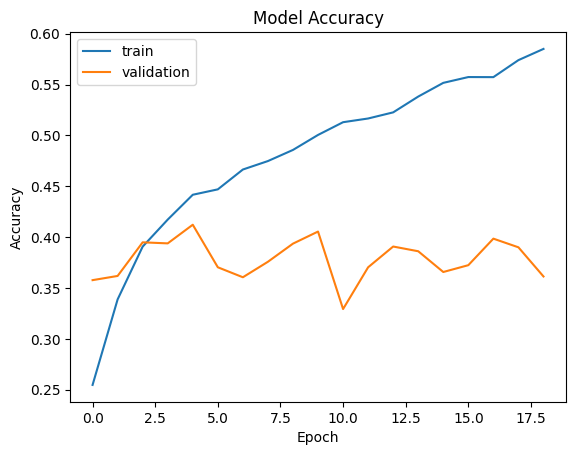

In [ ]:
plot_metric(training_history["densenet_base"])

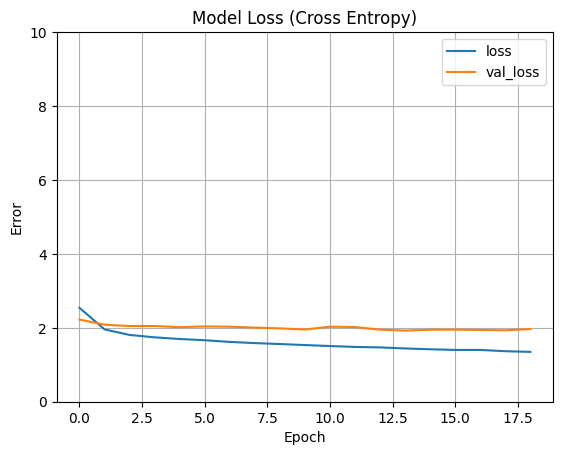

In [ ]:
plot_loss(training_history["densenet_base"])

As can be seen, the model's validation loss is not much worse than the training loss over 17 epochs. However, the real issue with the result is the large divergence between the training and validation accuracy.

While accuracy may not always be the most precise metric, the difference is quite striking. Although the hyperparameters seem to have hampered the model's ability to learn the training dataset's image features too well (generally low accuracy rate), the model still did not manage to generalize  well enough. The end result is a validation accuracy of a meager 41%.

In [ ]:
best_model_densenet = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224,224,3)),
    TFSMLayer('densenet_model', call_endpoint='serving_default')
])

In [ ]:
y_pred_prob = best_model_densenet.predict(val_densenet_unshuffled)

121/121 [==============================] - 19s 137ms/step


In [ ]:
label_map = {i: species for i, species in enumerate(y_train.columns)}

In [ ]:
y_pred = decode_predictions(y_pred_prob, label_map)

As can bee seen, the model predicted a lot of the species quite badly. Interestingly enough, a lot of species were predicted to be the monkey prosimian (27%), even though this species only appears in 14% of the images. The same applies to civet genet, although the difference is a bit smaller.

In [ ]:
y_pred.idxmax(axis = 1).value_counts(normalize = True)

monkey_prosimian    0.273244
civet_genet         0.177944
antelope_duiker     0.151601
leopard             0.121126
blank               0.110021
bird                0.077738
rodent              0.059143
hog                 0.029184
Name: proportion, dtype: float64

In [ ]:
y_val.idxmax(axis = 1).value_counts(normalize = True)

leopard             0.158058
rodent              0.156508
monkey_prosimian    0.142562
blank               0.125000
antelope_duiker     0.123709
civet_genet         0.112862
bird                0.102273
hog                 0.079029
Name: proportion, dtype: float64

In [ ]:
print(classification_report(y_pred = y_pred, y_true = y_val, target_names = y_val.columns.tolist()))

                  precision    recall  f1-score   support

 antelope_duiker       0.22      0.27      0.24       479
            bird       0.27      0.20      0.23       396
           blank       0.26      0.23      0.25       484
     civet_genet       0.38      0.60      0.47       437
             hog       0.64      0.24      0.34       306
         leopard       0.66      0.51      0.57       612
monkey_prosimian       0.35      0.67      0.46       552
          rodent       0.35      0.13      0.19       606

       micro avg       0.37      0.37      0.37      3872
       macro avg       0.39      0.36      0.34      3872
    weighted avg       0.39      0.37      0.35      3872
     samples avg       0.37      0.37      0.37      3872



In [ ]:
print("Accuracy score:", accuracy_score(y_pred = y_pred, y_true = y_val).round(3))

Accuracy score: 0.365


The Monkey prosimian's recall rate is quite good (0.67), although the precision score is, expectedly, relatively low, since a lot of species were predicted to be this animal.

Since not many species were predicted to be a hog and leopard, their precision rates are relatively high (~0.65). Interestingly though, the leopard seems to have also been misclassified as something else "only" 49% of the time, which is reflected in a relatively high F1-score.

The total **accuracy score is 0.36**, which is lower than during the training phase. The reason for that is that the data was shuffled, trained and evaluated on in batches, which introduced some additional noise. The validation accuracy scores were also averaged out over the batches during the training stage. In the case of the classificaiton report above, the validation data was evaluated on the entire set in one batch.

Similarly, the overall **Recall** and **Precision** rates are rather low (0.36 and 0.39), although they greatly differ from species to species.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

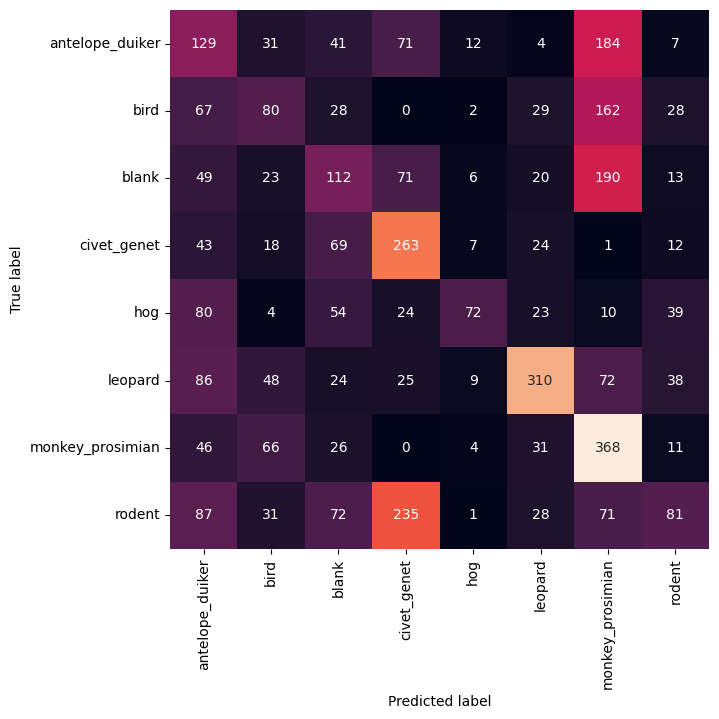

In [ ]:
mat = confusion_matrix(y_pred = y_pred.values.argmax(axis = 1), y_true = y_val.values.argmax(axis = 1))

plt.figure(figsize = (7,7))
map = sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
map.set_xlabel('Predicted label')
map.set_ylabel('True label')
map.set_xticklabels(label_map.values())
map.set_yticklabels(label_map.values())

plt.setp(map.get_xticklabels(), rotation = 90)
plt.setp(map.get_yticklabels(), rotation = 0)


The confusion matrix confirms the results from the classification report, but decyphers the classifications for individual species. It is clear that in some cases certain species tended to be classified as some other specific animal. For example, a lot of rodents were classified as civet genets. Likewise, antelope duikers, birds and images without any species tended to be classified as the monkey prosimian.

**ROC Curve and Area Under Curve (AUC) score**

As explained above, the ROC Curve and AUC score are additional important metrics that can be used to evalute how well the model separates the classes into distinct categories. First, the ROC Curve is shown below. The TPR and FPR for the "Rest" category were computed using macro-averaging.

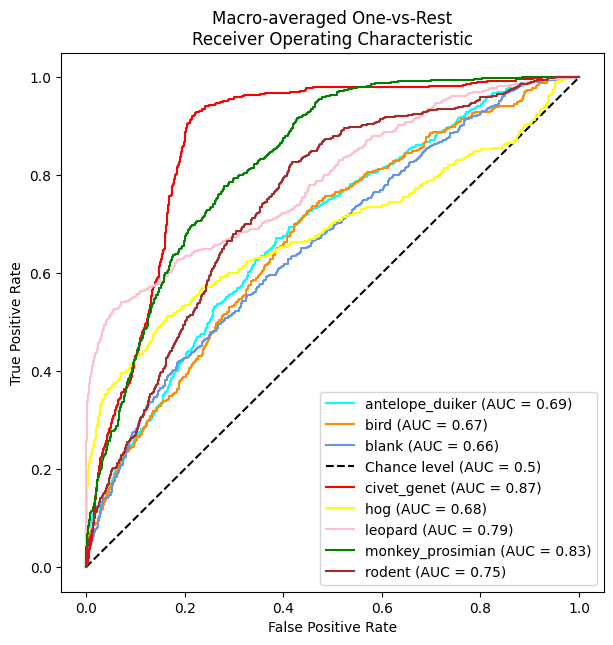

In [ ]:
roc_curve_total(y_true = y_val, y_pred = y_pred, label_map = label_map)

The **AUC scores** for the civet genet, monkey prosimian and the leopard are relatively high. This means that the model was able to distinguish between these animals individually and all the other ones combined.

Conversely, the model could not correctly classify many of the other species, such as rodents and birds.

While certain species were classified better than others, the overall result is not that good. It is worth noting that the train-validation split was done in such a way so as to produce two completely separate sets of sites in the two datasets. This rigorous split will ensure that the model is able to classify species from new sites in the future.

In the next section, the images are further augmented to help the model better classify the species.

**Saving the model**

In [ ]:
!mkdir -p saved_model
best_model_densenet.save('saved_model/densenet')

 48%|████▊     | 2134/4464 [21:48<23:48,  1.63it/s] 


### Image Augmentation

Apart from applying different weights to under-represented classes, there are a number of additional techniques which can be leveraged to balance out the distribution among species.

* Undersampling is a technique based around removing images from the dataset until the distribution of classes is equalized.
* Likewise, oversampling is almost the exact opposite of undersampling, except it randomly duplicates the underrepresented classes until there is a balance.
* In this case, a technique called Image Augmentation is used. Rather than introducing duplicates to the data, the process augments the images in some way, replacing the original image. Examples include shifting of images in any direction, zoom in or out, rotating or flipping. While this does not necessarily increase the number of data points, it does introduce "new", augmented images randomly. The model sees these examples and is able to learn more robust features, ultimately leading to better generalizability of the model.

Image augmentation techniques also have additional benefits other than balancing out the class distributions. Because the animals in the invidiual images are not always in the center of the picture, but sometimes appear too far to the left, or are simply too close to the camera, image transformations help level the playing field, making it easier for the model to better predict the different variations of images that exist in the dataset.

The ImageDataGenerator class from Keras is called to instantiate the image augmentation process. The following changes are applied to images:

* Rotation
* Shearing
* Shifts along the width and height
* Zooming in and out
* Different brightness levels
* Horizontal flip

In [16]:
train = keras.utils.image_dataset_from_directory(directory = "data/train",
                                               batch_size = 64,
                                               image_size = (224,224))

val = keras.utils.image_dataset_from_directory(directory = "data/valid",
                                               batch_size = 64,
                                               image_size = (224,224))

# Creating a list of augmentation layers

augmentation_layers = [
    prepro_input_dn201,
    #tf.keras.layers.RandomRotation(factor = 0.3, fill_mode = "nearest"),
    #tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor = 0.2, fill_mode = "nearest"),
    #keras_cv.layers.RandomShear(x_factor = 0.2, fill_mode = "nearest"),
    #tf.keras.layers.RandomZoom(height_factor = (-0.2, 0.2), fill_mode = "nearest"),
    #tf.keras.layers.RandomBrightness(factor = 0.5, value_range = [0, 1]),
    #keras_cv.layers.RandomSaturation(factor = (0.4,0.6)),
    #tf.keras.layers.RandomFlip("horizontal")
    ]

# Augmentation function to be applied to each image
def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_densenet_augmented = train.map(lambda x, y: (data_augmentation(x), tf.one_hot(y, depth = 8)))
val_densenet_augmented = val.map(lambda x, y: (data_augmentation(x), tf.one_hot(y, depth = 8)))

train_densenet_augmented = train_densenet_augmented.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
val_densenet_augmented = val_densenet_augmented.prefetch(buffer_size=tf.data.AUTOTUNE).cache()


Found 12616 files belonging to 8 classes.
Found 3872 files belonging to 8 classes.


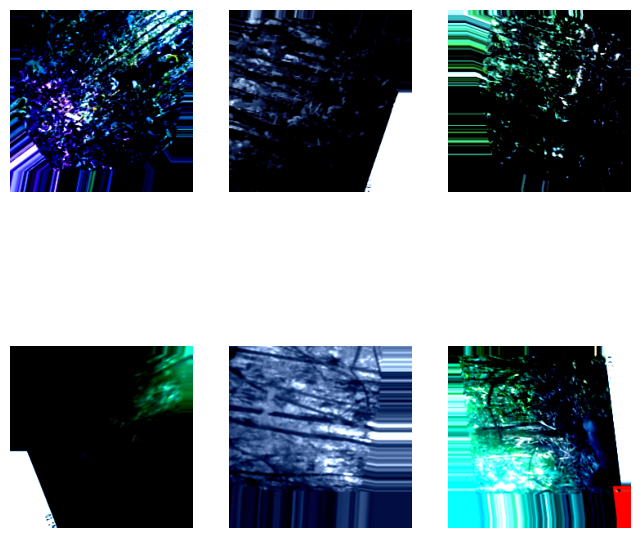

In [ ]:
images, labels = next(iter(train_densenet_augmented))

plt.figure(figsize=(8, 8))

for i in range(6):
    ax = plt.subplot(2,3, i + 1)

    plt.imshow(images[i])
    plt.axis("off")

In [21]:
seed = 65

optimize_densenet_augmented = keras_tuner.BayesianOptimization(hypermodel=DensenetHypermodel(),
                                                     objective = "val_accuracy",
                                                     max_trials = 12,
                                                    overwrite = True
                                                     #seed = seed
                                                               )

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 3, baseline = 2, start_from_epoch = 5, verbose = 1)

In [ ]:
optimize_densenet_augmented.search(train_densenet_augmented, validation_data = val_densenet_augmented, epochs = 20,
                                   callbacks = [es], class_weight = dict_weights_numbers, verbose = 1)

In [ ]:
best_hps_densenet_aug = optimize_densenet_augmented.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
best_model_densenet_aug = optimize_densenet_augmented.hypermodel.build(best_hps_densenet_aug)

In [ ]:
training_history["densenet_base_aug"] = best_model_densenet_aug.fit(train_densenet_augmented, validation_data = val_densenet_augmented, callbacks = [es],
                                                            class_weight = dict_weights, verbose = 1)

In [ ]:
plot_metric(training_history["densenet_base_aug"])

In [ ]:
plot_loss(training_history["densenet_base_aug"])

**Resnet101 model**

In [23]:
from tensorflow.keras.applications.resnet import preprocess_input as prepro_input_resnet

In [24]:
resnet_base = keras.applications.ResNet101(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

171446536/171446536 [==============================] - 1s 0us/step


In [25]:
for layers in resnet_base.layers[:]:
    layers.trainable = False

In [26]:
train = keras.utils.image_dataset_from_directory(directory = "data/train",
                                               batch_size = 64,
                                               image_size = (224,224))

val = keras.utils.image_dataset_from_directory(directory = "data/valid",
                                               batch_size = 64,
                                               image_size = (224,224))

train_resnet_augmented = train.map(lambda x, y: (prepro_input_resnet(x), tf.one_hot(y, depth = 8)))
val_resnet_augmented = val.map(lambda x, y: (prepro_input_resnet(x), tf.one_hot(y, depth = 8)))

train_resnet_augmented = train_resnet_augmented.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
val_resnet_augmented = val_resnet_augmented.prefetch(buffer_size=tf.data.AUTOTUNE).cache()

Found 12616 files belonging to 8 classes.
Found 3872 files belonging to 8 classes.


In [27]:
class ResnetHypermodel(keras_tuner.HyperModel):

  def build (self, hp = keras_tuner.HyperParameters()):

      #defining model

      K.clear_session()

      model = Sequential()

      # Data Augmentation

      model.add(tf.keras.layers.RandomRotation(factor = 0.2, fill_mode = "nearest"))
      model.add(tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor = 0.2, fill_mode = "nearest"))
      #model.add(keras_cv.layers.RandomShear(x_factor = 0.2, fill_mode = "nearest"))
      model.add(tf.keras.layers.RandomZoom(height_factor = (-0.2, 0.2), fill_mode = "nearest"))
      model.add(tf.keras.layers.RandomBrightness(factor = 0.1, value_range = [0, 1]))
      #model.add(keras_cv.layers.RandomSaturation(factor = (0.4,0.6)))
      model.add(tf.keras.layers.RandomFlip("horizontal"))


      model.add(resnet_base)

      model.add(Flatten())
      model.add(BatchNormalization())


      #Layer 1

      model.add(Dense(units = hp.Choice("units_1", [64, 128, 256, 512]),
                      kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
                      kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_1", min_value=1e-4, max_value=1e-1, sampling = "log")),
                      name = "dense1"))
      #if hp.Boolean("dropout_layer_1"):
      #  model.add(Dropout(rate = hp.Float("dropout_rate_1", min_value = 0, max_value = 0.5, step = 0.1)))
      model.add(BatchNormalization())
      model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))


    # Layer 2

      #model.add(Dense(units = hp.Choice("units_2", [32, 64, 128, 256, 512]),
      #                kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
      #                kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_2", min_value=1e-4, max_value=1e-1, sampling = "log")),
      #                name = "dense2"))
      #if hp.Boolean("dropout_layer_2"):
      #  model.add(Dropout(rate = hp.Float("dropout_rate_2", min_value = 0, max_value = 0.7, step = 0.1)))
      #model.add(BatchNormalization())
      #model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))


      # Layer 3

      #model.add(Dense(units = hp.Choice("units_3", [32, 64, 128, 256]),
      #                kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
      #                kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_3", min_value=1e-4, max_value=1e-1, sampling = "log")),
      #                name = "dense3"))
      #if hp.Boolean("dropout_layer_3"):
      #  model.add(Dropout(rate = hp.Float("dropout_rate_3", min_value = 0.1, max_value = 0.5, step = 0.1)))
      #model.add(BatchNormalization())
      #model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))



      # Output layer (softmax)
      model.add(Dense(units = 8, activation = "softmax", name = "output"))



      #compiling model

      lr = hp.Float("lr", min_value = 1e-4, max_value = 1e-1, sampling = "log")

      optimizers_dict = {
          "adam":    keras.optimizers.Adam(learning_rate = lr),
          "sgd":     keras.optimizers.SGD(learning_rate = lr, momentum =  hp.Float("momentum", min_value = 0.85, max_value = 0.95)),
          "rmsprop": keras.optimizers.RMSprop(learning_rate = lr)
          }

      hp_optimizers = hp.Choice('optimizer', values=["adam", "sgd", "rmsprop"])


      model.compile(optimizer = optimizers_dict[hp_optimizers], metrics = ["accuracy"],
                    loss = tf.keras.losses.CategoricalCrossentropy())

      return model


  def fit(self, hp, model, *args, **kwargs):
      return model.fit(*args, #epochs = hp.Int("epochs", min_value = 10, max_value = 20),
                       batch_size = hp.Choice("batch_size", [32, 64, 128, 256, 512]),
                       **kwargs)



In [28]:
ResnetHypermodel()

In [34]:
seed = 65

optimize_resnet_augmented = keras_tuner.BayesianOptimization(hypermodel=ResnetHypermodel(),
                                                     objective = "val_accuracy",
                                                     max_trials = 12,
                                                    overwrite = True
                                                     #seed = seed
                                                             )

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 3, baseline = 2, start_from_epoch = 5, verbose = 1)

In [ ]:
optimize_resnet_augmented.search(train_resnet_augmented, validation_data = val_resnet_augmented, epochs = 20,
                                   callbacks = [es], class_weight = dict_weights_numbers, verbose = 1)

Trial 1 Complete [00h 07m 02s]
val_accuracy: 0.20506198704242706

Best val_accuracy So Far: 0.20506198704242706
Total elapsed time: 00h 07m 02s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
256               |128               |units_1
uniform           |glorot_normal     |kernel_init
0.010036          |0.0094705         |kernel_reg_1
gelu              |relu              |activation
0.00034851        |0.017831          |lr
0.92797           |0.91393           |momentum
adam              |adam              |optimizer
512               |32                |batch_size

Epoch 1/20
198/198 [==============================] - 64s 278ms/step - loss: 57.2196 - accuracy: 0.2819 - val_loss: 13.2238 - val_accuracy: 0.1302
Epoch 2/20
198/198 [==============================] - 53s 268ms/step - loss: 4.1501 - accuracy: 0.3161 - val_loss: 10.6599 - val_accuracy: 0.1322
Epoch 3/20
198/198 [==============================] - 53s 267ms/step - loss: 2.3299 - accuracy: 0.326

**Predictions and evaluation on the validation set**

In [ ]:
y_pred_aug = best_model_densenet_aug.predict(val_densenet_unshuffled)

In [ ]:
y_pred_aug = decode_predictions(y_pred_aug, label_map)

In [ ]:
y_pred_aug.idxmax(axis = 1).value_counts(normalize = True)

In [ ]:
y_val.idxmax(axis = 1).value_counts(normalize = True)

In [ ]:
print(classification_report(y_pred = y_pred_aug, y_true = y_val, target_names = y_val.columns.tolist()))

In [ ]:
mat = confusion_matrix(y_pred = y_pred.values.argmax(axis = 1), y_true = y_val.values.argmax(axis = 1))

plt.figure(figsize = (7,7))
map = sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
map.set_xlabel('Predicted label')
map.set_ylabel('True label')
map.set_xticklabels(label_map.values())
map.set_yticklabels(label_map.values())

plt.setp(map.get_xticklabels(), rotation = 90)
plt.setp(map.get_yticklabels(), rotation = 0)


**ROC Curve and Area Under Curve (AUC) score**

In [ ]:
!mkdir -p saved_model
best_model_densenet_aug.save('saved_model/densenet_aug')